## Project : Identify customer segments for online retail with the use of K-means clustering

### Problem Satement:
Online retail companies generate massive volumes of customer transaction data every day. However, without proper analysis, this data provides little value in understanding customer behavior or designing effective marketing strategies. Retailers often struggle to personalize offers, manage customer relationships, and allocate marketing budgets without a clear understanding of different types of customers.

To address this issue, the goal of this project is to identify meaningful customer segments using K-Means clustering based on purchasing behavior. By analyzing attributes such as customer frequency, recency, and monetary value, we aim to uncover naturally occurring groups within the customer base. These segments will help the business:

- Recognize high-value customers

- Target customers who are likely to churn

- Design personalized marketing campaigns

- Improve customer retention

- Increase overall sales and engagement

The project involves cleaning and preparing the dataset, engineering important behavioral metrics (like RFM features), scaling the data, and applying K-Means clustering to group customers with similar purchasing patterns. The final output will provide clear insights into different customer segments along with recommendations for targeted business strategies.

### Attribute Information

*  InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
*  StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
*  Description: Product (item) name. Nominal.
*  Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal, the name of the country where each customer resides.

### Notebook Structure

1. Importing Libraries
2. Reading Data
3. Basic EDA
    1. Missing values
4. Data Preprocessing
    1. Removing the missing values
    2. Checking for duplicate rows
    3. Outliers
5. RFM Analysis
    1. Recency
    2. Frequency
    3. Monetary Value
6. Clustering products into product categories
    1. The Elbow Method
    2. Silhoutte Analysis
    3. Visualizing the clusters
7. Customer Segmentation using Unsupervised Learning
    1. K-Means Clustering
8. Understanding Clusters


### 1.Importing Libraries

In [175]:
#basic libraries for linear algebra and data procesing
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

#time and warnings
import time
import warnings

#settings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_context('poster', font_scale=0.5)

### 2. Reading Data

In [176]:
# read the dataset
retail_df = pd.read_excel('Online Retail.xlsx')


### 3. Basic EDA

In [177]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [178]:
#Getting rows and columns data
retail_df.shape

(541909, 8)

In [179]:
# basics of the dataframe
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [180]:
# How many unique products?
print(retail_df['StockCode'].nunique())
print(retail_df['Description'].nunique())

4070
4223


In [181]:
# new column: amount 
retail_df['Total Price'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [182]:
# How many of each product are there?
retail_df['Description'].value_counts().head()

Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: count, dtype: int64

In [183]:
# How many customers are there?
retail_df["CustomerID"].value_counts()

CustomerID
17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
15070.0       1
15753.0       1
17065.0       1
16881.0       1
16995.0       1
Name: count, Length: 4372, dtype: int64

### Missing values

In [184]:
#Exploring the number of missing values per feature in percentage
print('Number of missing values: ', retail_df.isnull().values.sum())
print('Percent of missing values per feature: ') 
round(retail_df.isnull().sum() * 100 / len(retail_df),2)

Number of missing values:  136534
Percent of missing values per feature: 


InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
Total Price     0.00
dtype: float64

CustomerID – 24.93% Missing (Most Important Column), drop the rows where CustomerID is missing. Customer segmentation requires customer-level analysis. Without CustomerID, you cannot compute RFM (Recency, Frequency, Monetary).These rows cannot be assigned to any customer → they are useless for segmentation. Description – 0.27% missing best way to drop.

In [185]:
#Removing missing values of both the columns
retail_df.dropna(inplace=True)


In [186]:
# Again checking for missing values
retail_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Total Price    0
dtype: int64

In [187]:
# Getting data length as well as missing value count
print('Number of missing values: ', retail_df.isnull().values.sum())
print('Data lenght: ', len(retail_df))

Number of missing values:  0
Data lenght:  406829


### Checking for duplicate rows and Cancellation records indicated as "C"


In [188]:
#Checking for duplicate rows
retail_df.duplicated().sum()

5225

In [189]:
# Remove duplicate records from a dataframe
retail_df.drop_duplicates(inplace=True)

#Drop some  InvoiceNo  which are starts with 'C' because 'C', it indicates a cancellation
retail_df = retail_df[~retail_df['InvoiceNo'].astype(str).str.contains('C')]

retail_df.shape

(392732, 9)

In [190]:
#Reading description data
Description_df=retail_df['Description'].value_counts().reset_index()

Description_df

,Description,count
0,WHITE HANGING HEART T-LIGHT HOLDER,2016
1,REGENCY CAKESTAND 3 TIER,1714
2,JUMBO BAG RED RETROSPOT,1615
3,ASSORTED COLOUR BIRD ORNAMENT,1395
4,PARTY BUNTING,1390
...,...,...
3872,GREEN WITH METAL BAG CHARM,1
3873,WHITE WITH METAL BAG CHARM,1
3874,BLUE/NAT SHELL NECKLACE W PENDANT,1
3875,PINK EASTER HENS+FLOWER,1


#### Top 5 selling products 

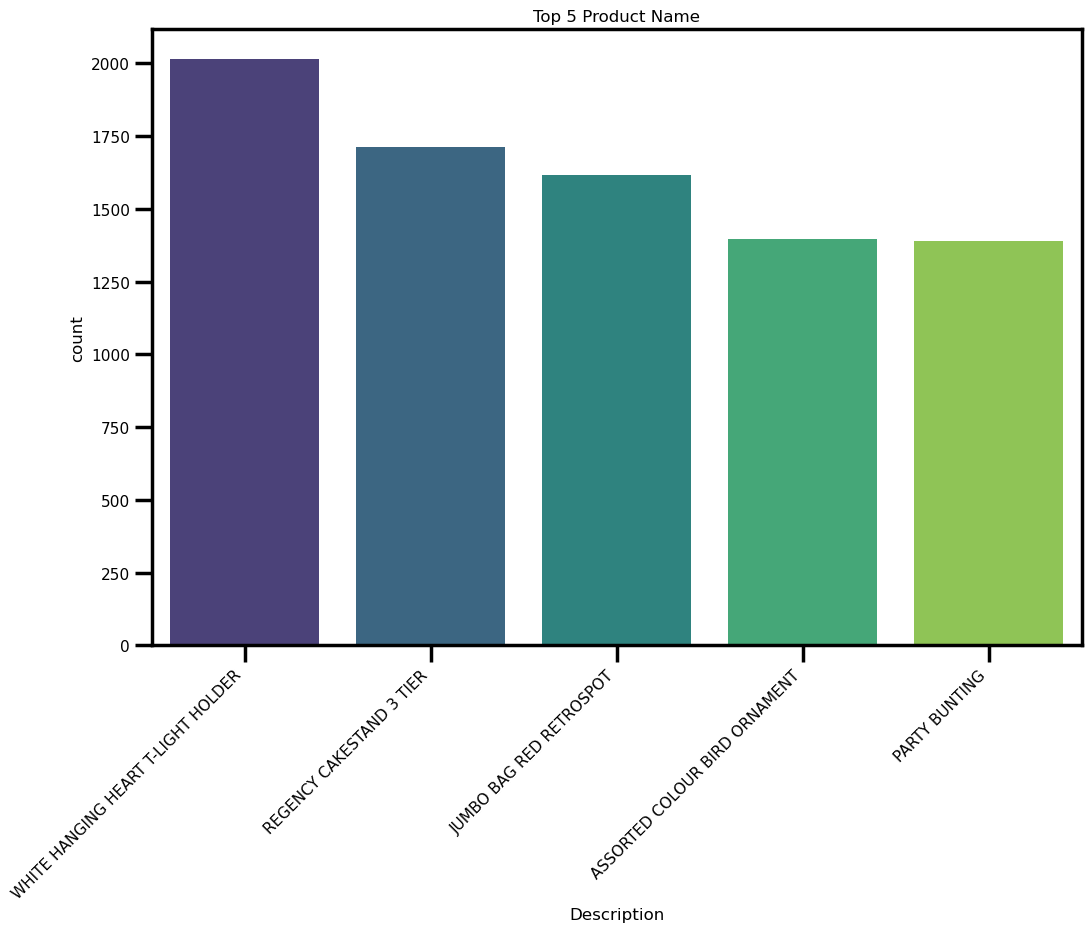

In [191]:
#Top products based on selling 
plt.figure(figsize=(12,8))
plt.title('Top 5 Product Name')
plt.xticks(rotation=45, ha='right')
sns.barplot(x='Description', y='count', data=Description_df[:5], palette="viridis")
plt.show()

#### Top 5 least selling products

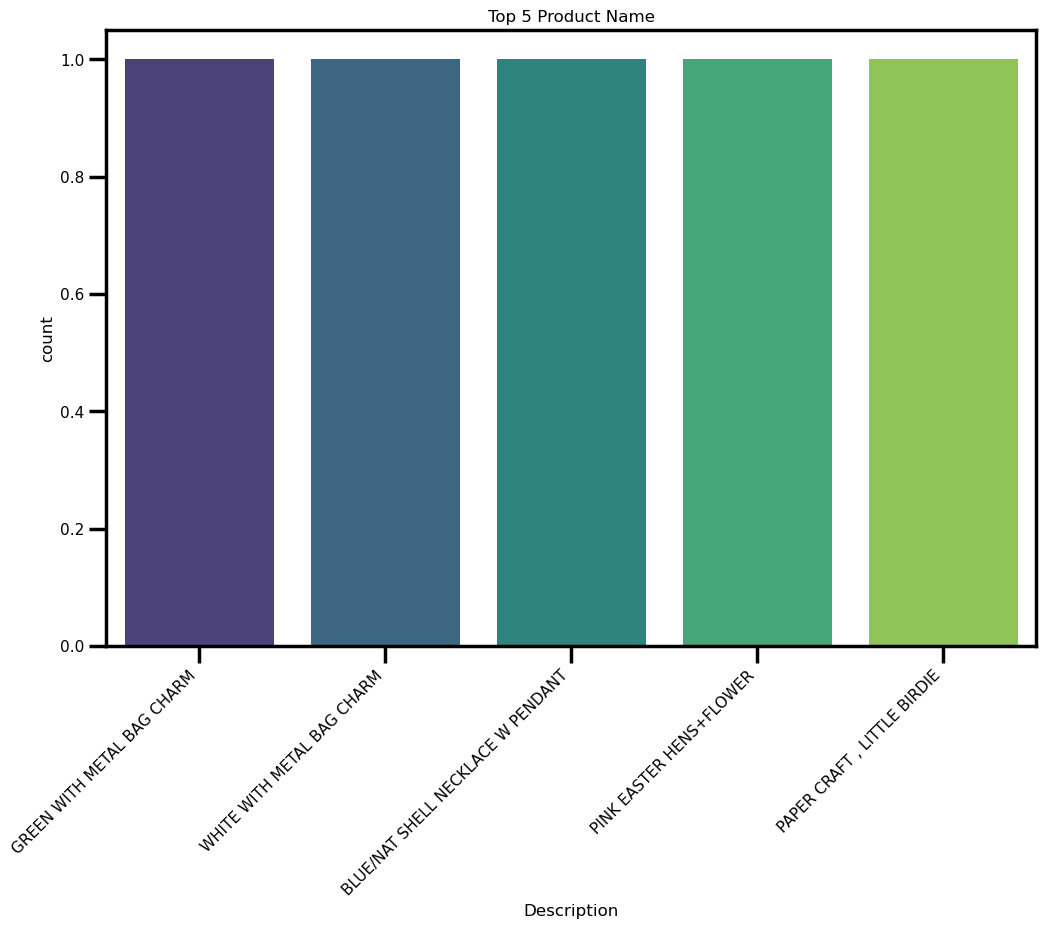

In [192]:
#Bottom products based on selling 
plt.figure(figsize=(12,8))
plt.title('Top 5 Product Name')
plt.xticks(rotation=45, ha='right')
sns.barplot(x='Description', y='count', data=Description_df[-5:], palette="viridis")
plt.show()

In [193]:
#Reading StockCode data
stock_df=retail_df['StockCode'].value_counts().reset_index()
stock_df.head()

,StockCode,count
0,85123A,2023
1,22423,1714
2,85099B,1615
3,84879,1395
4,47566,1390


#### Top 5 selling stockcode

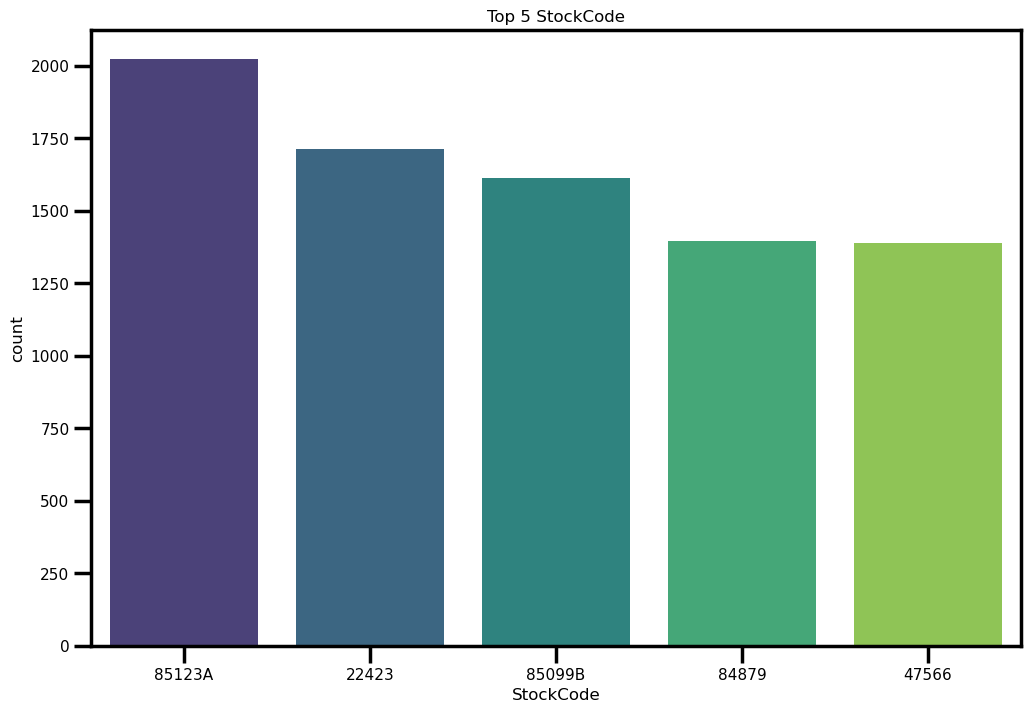

In [194]:
#Top 5 StockCode based on selling 
plt.figure(figsize=(12,8))
plt.title('Top 5 StockCode')
sns.barplot(x='StockCode', y='count', data=stock_df[:5], palette="viridis")
plt.show()

#### Top 5 least selling stockcode

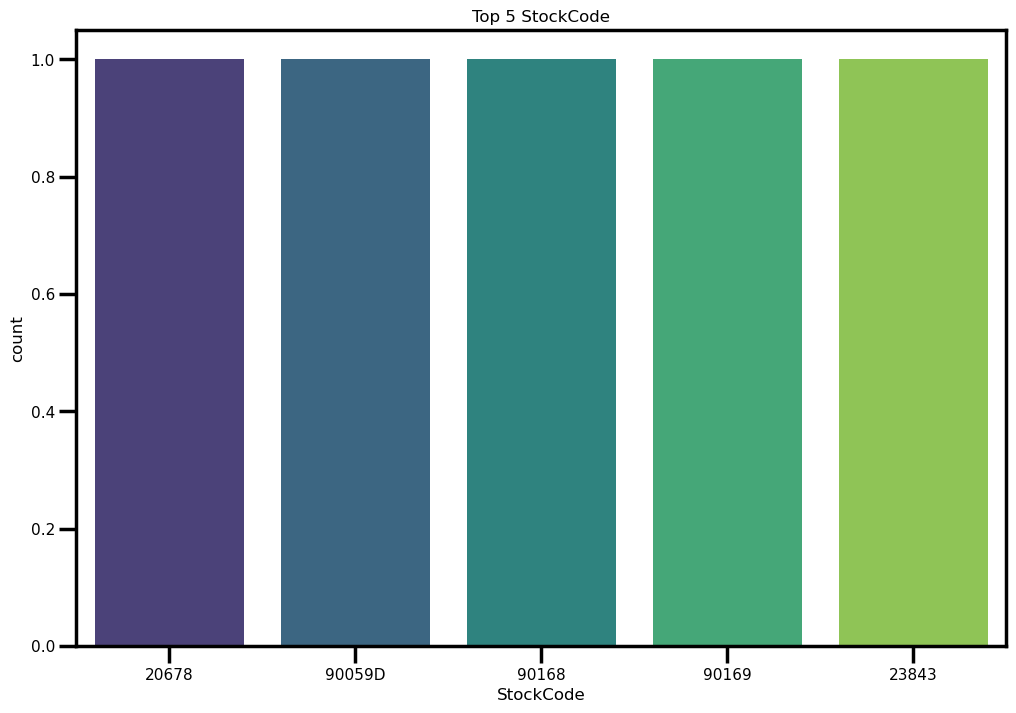

In [195]:
#Bottom 5 StockCode based on selling 
plt.figure(figsize=(12,8))
plt.title('Top 5 StockCode')
sns.barplot(x='StockCode', y='count', data=stock_df[-5:], palette="viridis")
plt.show()

In [196]:
#Reading country data
country_df=retail_df['Country'].value_counts().reset_index()
country_df.head()

,Country,count
0,United Kingdom,349227
1,Germany,9027
2,France,8327
3,EIRE,7228
4,Spain,2480


#### Top 5 selling countries

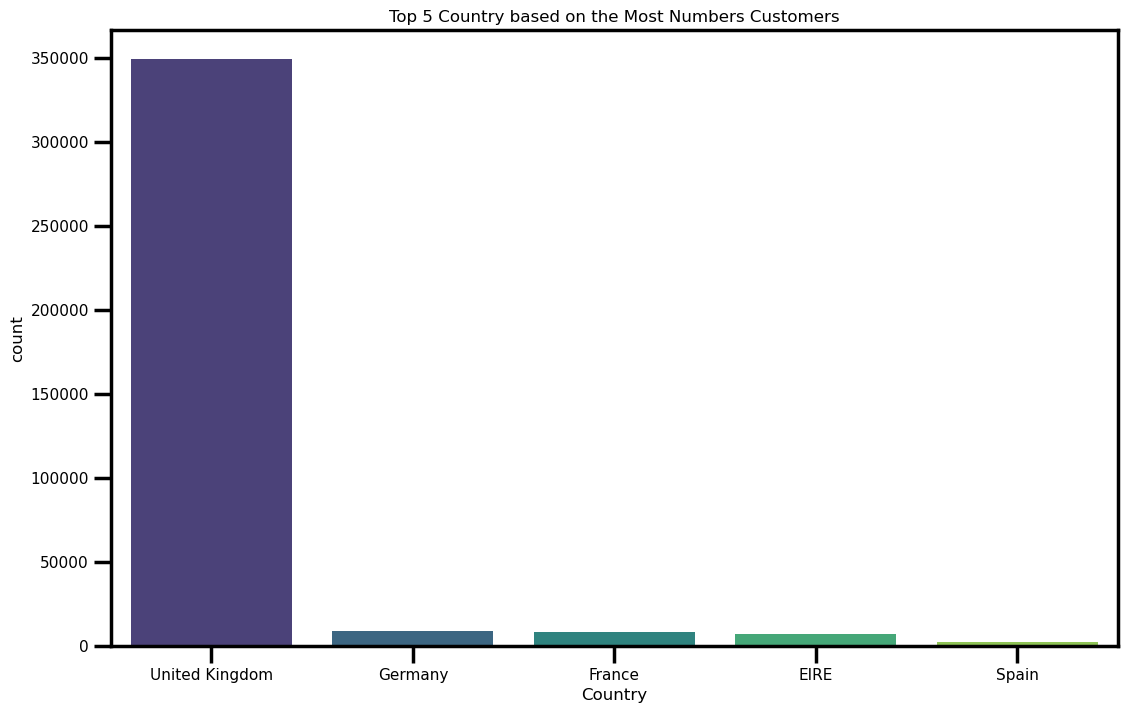

In [197]:
#Top 5 Countries based on selling 
plt.figure(figsize=(13,8))
plt.title('Top 5 Country based on the Most Numbers Customers')
sns.barplot(x='Country',y='count',data=country_df[:5], palette="viridis")
plt.show()

From this graph we can see that most of the customers are from United Kingdom ,Germany ,France ,EIRE and Spain

#### Top 5 least selling countries

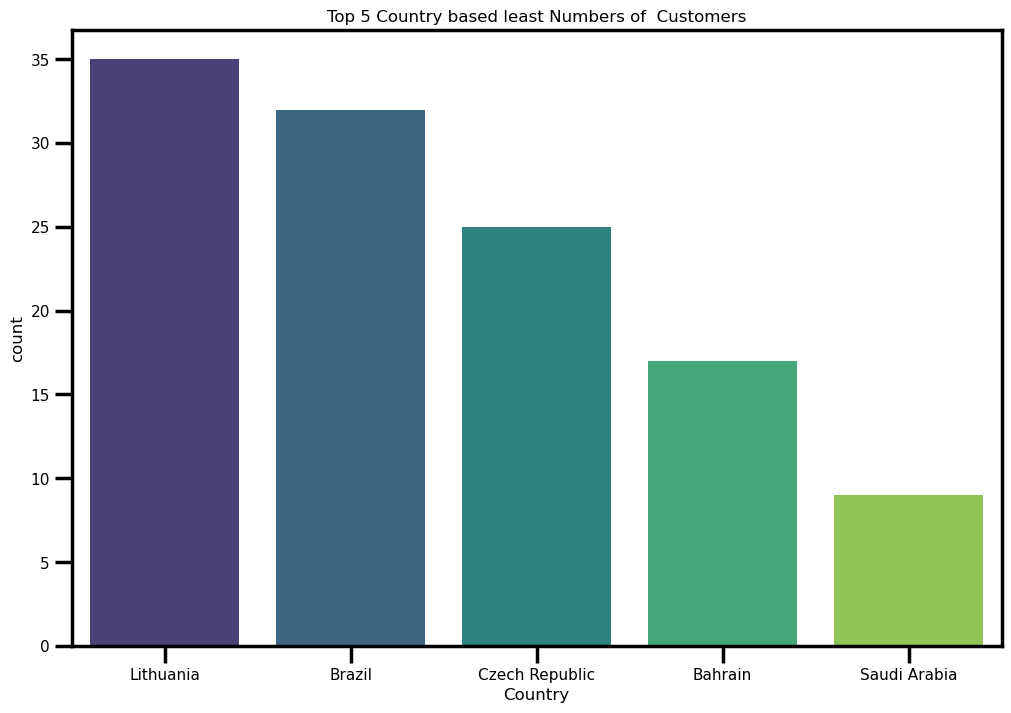

In [198]:
#Bottom 5 Countries based on selling 
plt.figure(figsize=(12,8))
plt.title('Top 5 Country based least Numbers of  Customers')
sns.barplot(x='Country', y='count', data=country_df[-5:], palette="viridis")
plt.show()

From this graph we can see that least number of customers from Lithuania,Brazil, Czech Republic ,Bahrain  and Saudi Arabia

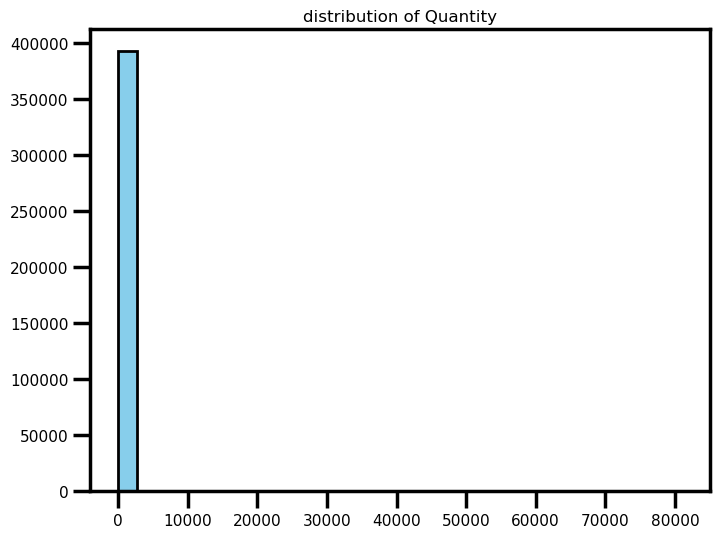

In [199]:
#distribution of Quantity
plt.figure(figsize=(8,6))
plt.title('distribution of Quantity')

plt.hist(retail_df["Quantity"], bins=30, color='skyblue', edgecolor='black')
plt.show()

The Quantity variable is extremely skewed.Almost all bars are squeezed at the left side (0–100 range).
This means:Most customers buy very low quantities per transaction.few records have extremely high Quantity values
We can see the X-axis extending up to 80,000, even though almost no data appears there.
This indicates:There are extreme outliers.Possibly bulk orders or incorrect entries.These values crush the histogram and distort visibility

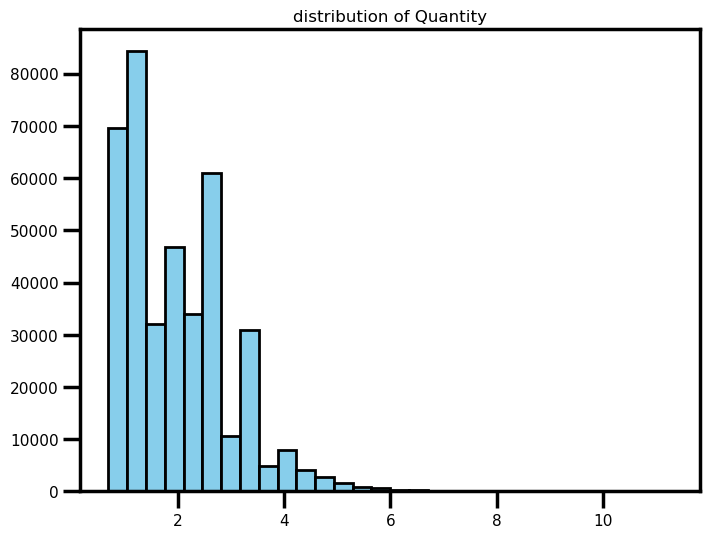

In [200]:
#log distribution of Quantity
plt.figure(figsize=(8,6))
plt.title('distribution of Quantity')

plt.hist(np.log1p(retail_df["Quantity"]), bins=30, color='skyblue', edgecolor='black')
plt.show()

In [201]:
# Getting summary quantity
retail_df['Quantity'].describe()

count    392732.000000
mean         13.153718
std         181.588420
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

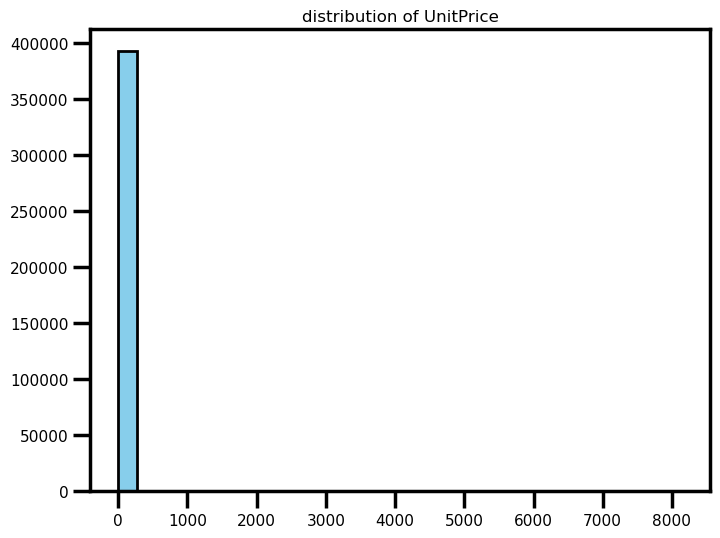

In [202]:
#distribution of UnitPrice
plt.figure(figsize=(8,6))
plt.title('distribution of UnitPrice')

plt.hist(retail_df["UnitPrice"], bins=30, color='skyblue', edgecolor='black')
plt.show()

Most UnitPrice values are very low (0–50 range).Almost all data is squeezed at the left side of the graph. A few UnitPrice values are extremely high (hundreds or even thousands).The x-axis goes up to 8000, even though almost no data appears there.The dataset contains outliers.

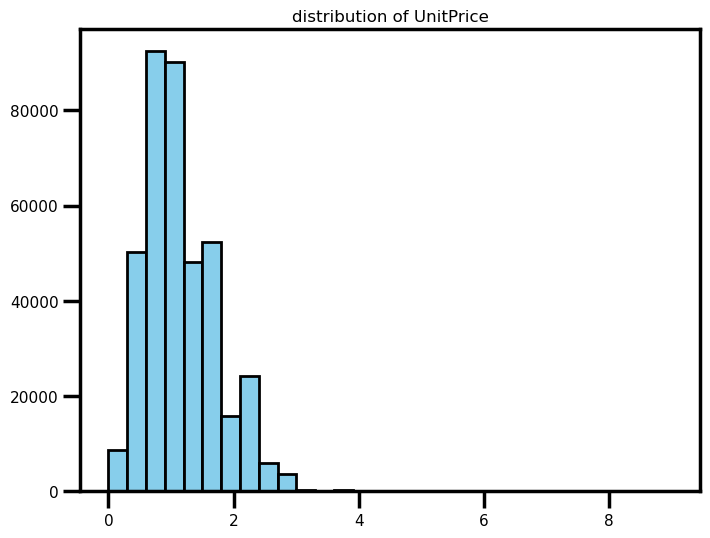

In [203]:
#log distribution of UnitPrice
plt.figure(figsize=(8,6))
plt.title('distribution of UnitPrice')

plt.hist(np.log1p(retail_df["UnitPrice"]), bins=30, color='skyblue', edgecolor='black')
plt.show()

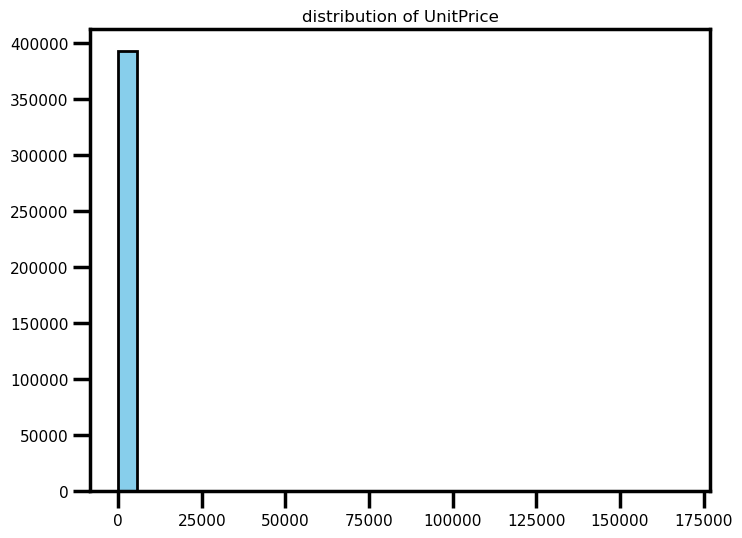

In [204]:
#distribution of Total Price
plt.figure(figsize=(8,6))
plt.title('distribution of UnitPrice')

plt.hist(retail_df["Total Price"], bins=30, color='skyblue', edgecolor='black')
plt.show()

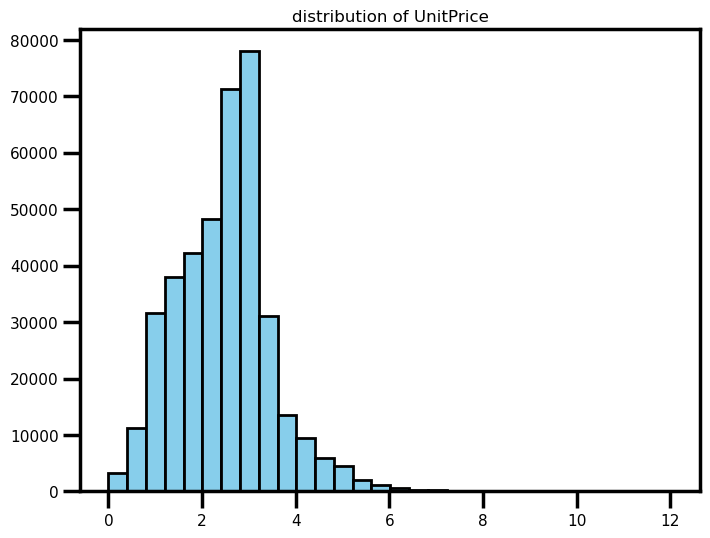

In [205]:
#distribution of Total Price
plt.figure(figsize=(8,6))
plt.title('distribution of UnitPrice')

plt.hist(np.log1p(retail_df["Total Price"]), bins=30, color='skyblue', edgecolor='black')
plt.show()

Same applies here like quantity and unit price.

### Checking for outliers
To remove outliers safely in the Online Retail dataset (especially before creating RFM and performing K-Means clustering), we must follow a method that removes only true errors while keeping valuable business behaviour.


In [206]:
# summary of descriptive statistics for a dataframe
retail_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Total Price
count,392732.000000,392732,392732.000000,392732.000000,392732.000000
mean,13.153718,2011-07-10 19:15:24.576301568,3.125596,15287.734822,22.629195
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000,0.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13955.000000,4.950000
50%,6.000000,2011-07-31 12:02:00,1.950000,15150.000000,12.390000
75%,12.000000,2011-10-20 12:53:00,3.750000,16791.000000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000
std,181.588420,NaN,22.240725,1713.567773,311.083465


#### Interpretation
1. Quantity: Most quantities are small (median = 5)
    - But there are extreme outliers on both sides (+80,995 and -80,995!)
    - The negative quantities represent returns/refunds
    - We cannot include Quantity directly in clustering because,
    - It's highly skewed      
    - Contains massive outliers
    - StandardScaler will distort it
    - Usually, you use Frequency, not raw Quantity.
2. InvoiceDate: You won’t use InvoiceDate directly.You will convert it into Recency.
3. UnitPrice: Most products cost ₹1–₹4. But one item costs £38,970 → huge outlier. Many items have 0 price → likely errors or promotions

In [207]:
#Getting informations of columns
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  float64       
 7   Country      392732 non-null  object        
 8   Total Price  392732 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.0+ MB


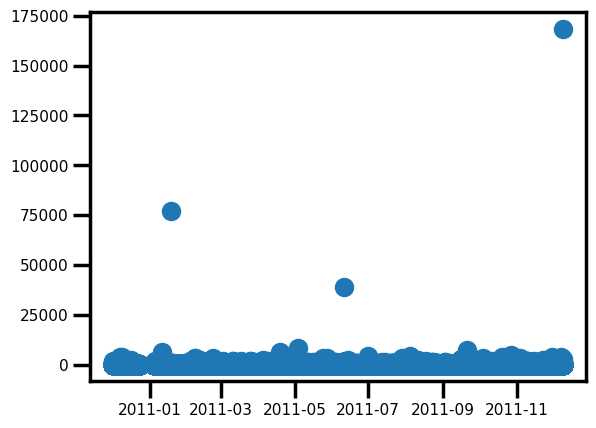

In [208]:
# we will see scatter plot for amount instead of Quantity as we are using amount in RFM analysis
plt.scatter(retail_df['InvoiceDate'], retail_df['Total Price'])
plt.show()


In [209]:
#As we will deal with Total price removing outliers from total price will also remove outlier data related to quantity
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

retail_df = remove_outliers_iqr(retail_df, 'Total Price')

In [210]:
#Summary of descriptive statistics for dataframe
retail_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Total Price
count,386933.000000,386933,386933.000000,386933.000000,386933.000000
mean,10.284520,2011-07-10 20:11:05.100882944,2.898175,15289.038810,16.494300
min,1.000000,2010-12-01 08:26:00,0.000000,12347.000000,0.000000
25%,2.000000,2011-04-07 10:33:00,1.250000,13959.000000,4.950000
50%,5.000000,2011-07-31 12:16:00,1.950000,15152.000000,11.800000
75%,12.000000,2011-10-20 13:46:00,3.750000,16791.000000,19.500000
max,12540.000000,2011-12-09 12:50:00,165.000000,18287.000000,166.800000
std,28.385725,NaN,3.693942,1712.249599,20.393642


We still have some -ve values we need to remove it.

In [211]:


#Remove negative or zero of Total Price
retail_df = retail_df[retail_df['Total Price'] > 0]
retail_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Total Price
count,386893.000000,386893,386893.000000,386893.000000,386893.000000
mean,10.249697,2011-07-10 20:08:46.591331584,2.898475,15289.149623,16.496005
min,1.000000,2010-12-01 08:26:00,0.001000,12347.000000,0.001000
25%,2.000000,2011-04-07 10:33:00,1.250000,13959.000000,4.950000
50%,5.000000,2011-07-31 12:08:00,1.950000,15152.000000,11.800000
75%,12.000000,2011-10-20 13:46:00,3.750000,16791.000000,19.500000
max,2400.000000,2011-12-09 12:50:00,165.000000,18287.000000,166.800000
std,19.989671,NaN,3.694015,1712.220710,20.394007


### Feature Engineering


In [212]:
# Adding new features i.e separating invoice date into days, months,year and time format for further analysis
retail_df["year"] = retail_df["InvoiceDate"].apply(lambda x: x.year)
retail_df["month_num"] = retail_df["InvoiceDate"].apply(lambda x: x.month)
retail_df["day_num"] = retail_df["InvoiceDate"].apply(lambda x: x.day)
retail_df["hour"] = retail_df["InvoiceDate"].apply(lambda x: x.hour)
retail_df["minute"] = retail_df["InvoiceDate"].apply(lambda x: x.minute)

retail_df['Month']=retail_df['InvoiceDate'].dt.month_name()
retail_df['Day']=retail_df['InvoiceDate'].dt.day_name()
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price,year,month_num,day_num,hour,minute,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,8,26,December,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,26,December,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,8,26,December,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,26,December,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,26,December,Wednesday


In [213]:
# Count of purchases happened in each day
day_df=retail_df['Day'].value_counts().reset_index()
day_df.rename(columns={'Day': 'Day_Name'}, inplace=True)
day_df.rename(columns={'Day': 'Count'}, inplace=True)
day_df

,Day_Name,count
0,Thursday,77805
1,Wednesday,66851
2,Tuesday,64633
3,Monday,63334
4,Sunday,60922
5,Friday,53348


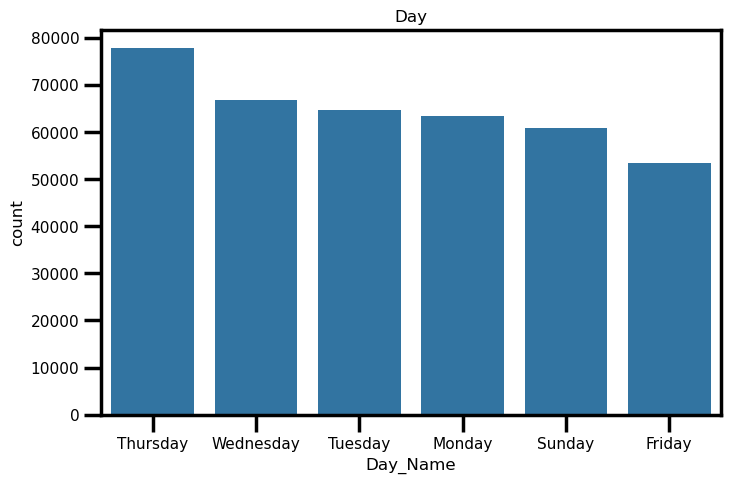

In [214]:
#Plotting barplot
plt.figure(figsize=(8,5))
plt.title('Day')
sns.barplot(x='Day_Name',y='count',data=day_df)
plt.show()

Most of the customers have purches the items in Thursday

In [215]:
#Count of purchases happened in each month
month_df=retail_df['Month'].value_counts().reset_index()
month_df.rename(columns={'Month': 'Month_Name'}, inplace=True)
month_df.rename(columns={'Month': 'count'}, inplace=True)
month_df

,Month_Name,count
0,November,62456
1,October,48080
2,December,42136
3,September,39002
4,May,27568
5,June,26480
6,March,26471
7,August,26260
8,July,26138
9,April,22172


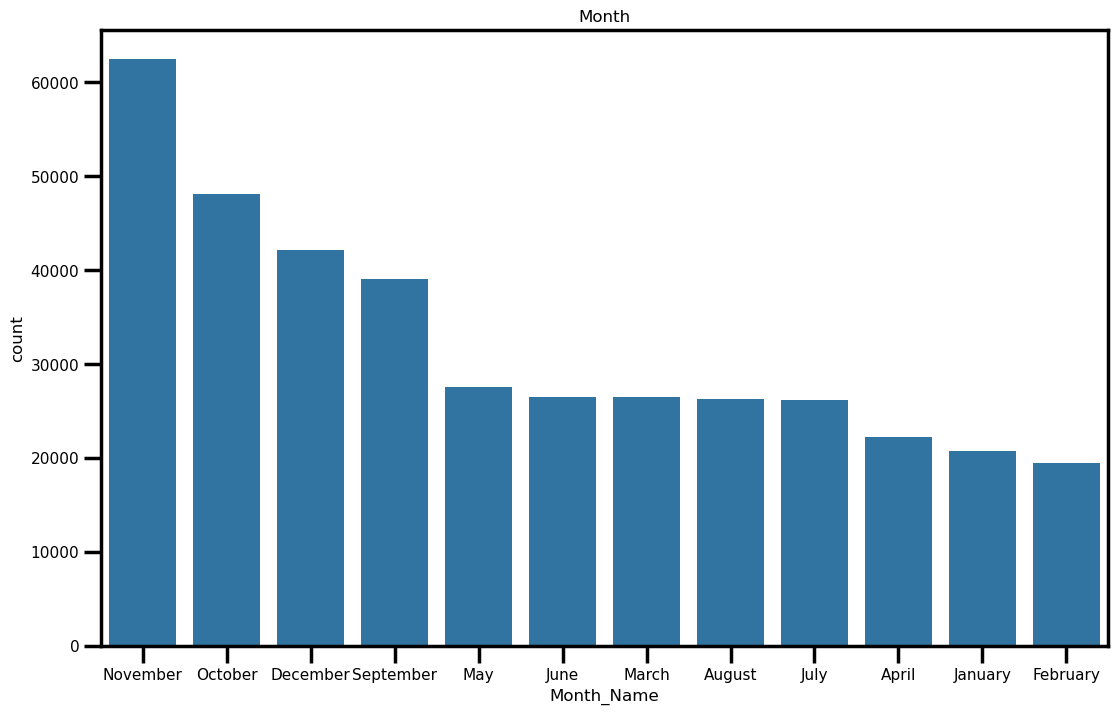

In [216]:
#Plotting barplot
plt.figure(figsize=(13,8))
plt.title('Month')
sns.barplot(x='Month_Name',y='count',data=month_df)
plt.show()

most numbers of customers have purches the gifts in the month of November ,October and December September<br>
less numbers of customers have purches the gifts in the month of April ,january and February

In [217]:
#Count of purchases happened in each hour
hour_df=retail_df['hour'].value_counts().reset_index()
hour_df.rename(columns={'hour': 'Hour_Name'}, inplace=True)
hour_df.rename(columns={'hour': 'count'}, inplace=True)
hour_df

,Hour_Name,count
0,12,70124
1,13,62327
2,14,52699
3,11,47514
4,15,44223
5,10,36751
6,16,23416
7,9,21442
8,17,12799
9,8,8483


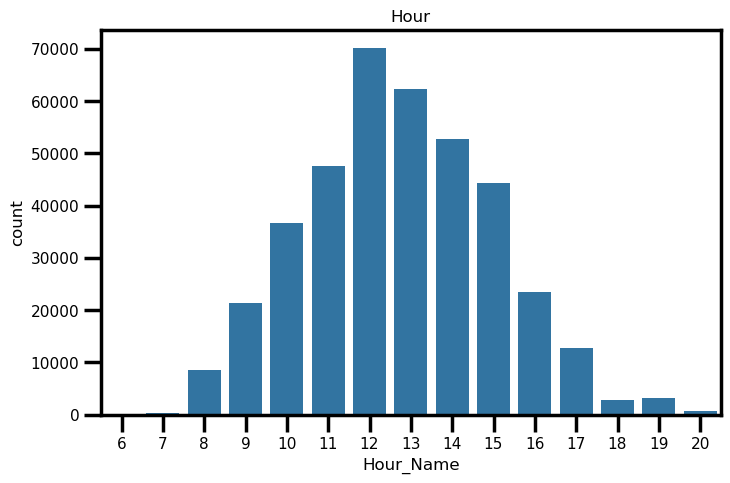

In [218]:
#Plotting graph
plt.figure(figsize=(8,5))
plt.title('Hour')
sns.barplot(x='Hour_Name',y='count',data=hour_df)
plt.show()

From this graph we can see that in AfterNone Time most of the customers have purches the item

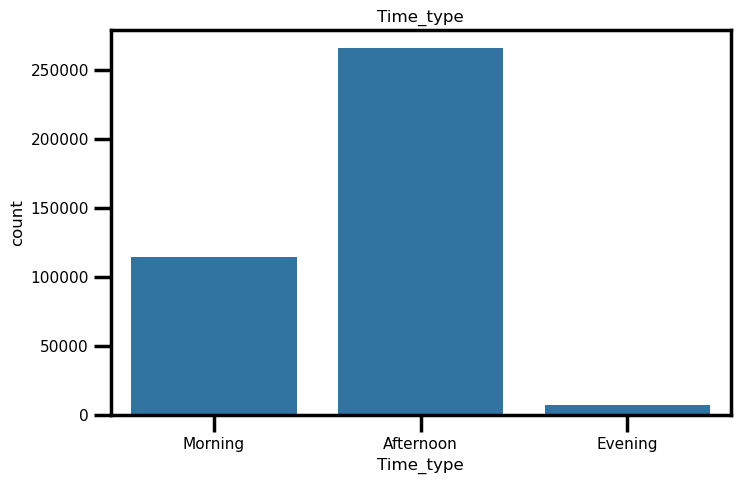

In [219]:
# function to define if it is moring or afternoon or evening depend on hour time
def time_type(time):
  if(time==6 or time==7 or time==8 or time==9 or time==10 or time==11):
    return 'Morning'
  elif(time==12 or time==13 or time==14 or time==15 or time==16 or time==17):
    return 'Afternoon'
  else:
    return 'Evening'
  
retail_df['Time_type']=retail_df['hour'].apply(time_type)
#Plot a graph to check what time of day max purcahses happend
plt.figure(figsize=(8,5))
plt.title('Time_type')
sns.countplot(x='Time_type',data=retail_df)
plt.show()

Most of the customers have purches the items in Aftrnoon ,moderate numbers of customers have purches the items in Morning and least numbers of customers have purches the items in Evening


### 5. RFM Analysis 
   - R (Recency): Number of days since last purchase
   - F (Frequency): Number of tracsactions
   - M (Monetary): Total amount of transactions (revenue contributed)
   - RFM Segmentation using scores    
   - Visualizing the RFM Level customers using a bar plot

In [220]:
# Monetary Value
total = retail_df.groupby('CustomerID')['Total Price'].sum()
total= total.reset_index()
total.head()

,CustomerID,Total Price
0,12347.0,4060.40
1,12348.0,1557.24
2,12349.0,1457.55
3,12350.0,334.40
4,12352.0,1665.74


In [221]:
# frequency
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12347.0,181
1,12348.0,30
2,12349.0,72
3,12350.0,17
4,12352.0,82


In [222]:
# Merge Dataframe unit price and frequency
tot_freq = pd.merge(total, frequency, on='CustomerID', how='inner')
tot_freq.head()
print("Size : ",tot_freq.shape)


Size :  (4283, 3)


In [223]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price,year,month_num,day_num,hour,minute,Month,Day,Time_type
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,8,26,December,Wednesday,Morning
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,26,December,Wednesday,Morning
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,8,26,December,Wednesday,Morning
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,26,December,Wednesday,Morning
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,26,December,Wednesday,Morning


In [224]:
# convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')

In [225]:
# calculate the date diffenve of the max date and the last purchase i.e invoiceDate
max_date = max(retail_df['InvoiceDate'])
retail_df['Diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price,year,month_num,day_num,hour,minute,Month,Day,Time_type,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1,8,26,December,Wednesday,Morning,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,26,December,Wednesday,Morning,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1,8,26,December,Wednesday,Morning,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,26,December,Wednesday,Morning,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1,8,26,December,Wednesday,Morning,373 days 04:24:00


In [226]:
# recency
last_purchase = retail_df.groupby('CustomerID')['Diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,Diff
0,12347.0,1 days 20:58:00
1,12348.0,74 days 23:37:00
2,12349.0,18 days 02:59:00
3,12350.0,309 days 20:49:00
4,12352.0,35 days 22:13:00


In [227]:
# merge
rfm_df = pd.merge(tot_freq, last_purchase, on='CustomerID', how='inner')
rfm_df.columns = ['CustomerID', 'Total Price', 'Frequency', 'Recency']
rfm_df.head()

,CustomerID,Total Price,Frequency,Recency
0,12347.0,4060.40,181,1 days 20:58:00
1,12348.0,1557.24,30,74 days 23:37:00
2,12349.0,1457.55,72,18 days 02:59:00
3,12350.0,334.40,17,309 days 20:49:00
4,12352.0,1665.74,82,35 days 22:13:00


In [228]:
# Filter the time character keep the no of days only. 
rfm_df['Recency'] = rfm_df['Recency'].dt.days
rfm_df.head()

,CustomerID,Total Price,Frequency,Recency
0,12347.0,4060.40,181,1
1,12348.0,1557.24,30,74
2,12349.0,1457.55,72,18
3,12350.0,334.40,17,309
4,12352.0,1665.74,82,35


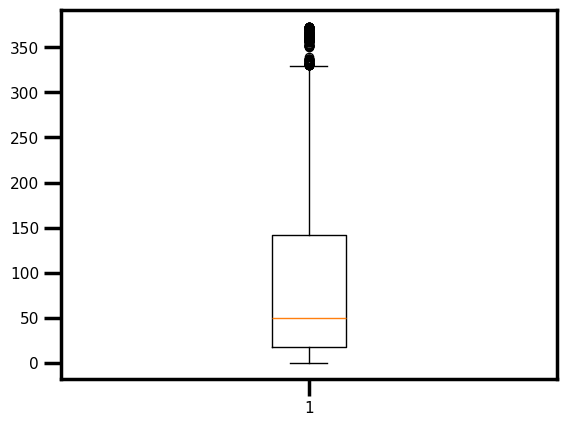

In [229]:
#Plotting boxplot for recency
plt.boxplot(rfm_df['Recency'])
plt.show()

Here we are not going to remove outlier because a customer who bought 300 days ago is not an outlier — they are simply inactive.<br>
Analysis:
- Low recency → Recent buyers (active customers)
- High recency → Dormant customers
- Very high recency → Lost customers<br>

If you remove large recency values, you lose the ability to identify Lost customers, At-risk customers, Occasional buyers.

- High-frequency customers = loyal customers
- High-monetary customers = premium customers<br>
These are key customer segments (VIP, Champions)Removing them breaks the business insights.

### RFM Segmentation using scores

The customers are grouped into different segments based on their RFM level, and calculate the mean values for recency, frequency, and monetary value for each segment. 
The result I get is a summary table that provides us with valuable insights into the behavior of each segment of customers.

In [230]:
#normalizing the values
r_quartile = pd.qcut(rfm_df['Recency'], 4, labels=[4, 3, 2, 1])
f_quartile = pd.qcut(rfm_df['Frequency'], 4, labels=[1, 2, 3, 4])
m_quartile = pd.qcut(rfm_df['Total Price'], 4, labels=[1, 2, 3, 4])
rfm_df['RFM_Score'] = r_quartile.astype(int) + f_quartile.astype(int) + m_quartile.astype(int)

In [231]:
#creating the rfm_level function
def assign_rfm_level(row):
    """
    
    This function assigns the RFM level based on the RFM score.
    :parameter: RFM scores from the dataframe
    :return: The RFM level category as string
    
    """

    if row['RFM_Score'] >= 10:
        return 'Best Customers'
    elif (row['RFM_Score'] < 10) and (row['RFM_Score'] >= 6):
        return 'Loyal Customers'
    elif (row['RFM_Score'] < 6) and (row['RFM_Score'] >= 4):
        return 'Potential Loyalists'
    elif (row['RFM_Score'] < 4) and (row['RFM_Score'] >= 2):
        return 'Promising'
    else:
        return 'Needs Attention'

rfm_df['RFM_Level'] = rfm_df.apply(assign_rfm_level, axis=1)

In [232]:
rfm_df.head()

,CustomerID,Total Price,Frequency,Recency,RFM_Score,RFM_Level
0,12347.0,4060.40,181,1,12,Best Customers
1,12348.0,1557.24,30,74,8,Loyal Customers
2,12349.0,1457.55,72,18,9,Loyal Customers
3,12350.0,334.40,17,309,4,Potential Loyalists
4,12352.0,1665.74,82,35,10,Best Customers


### Visualizing the RFM Level customers using a bar plot

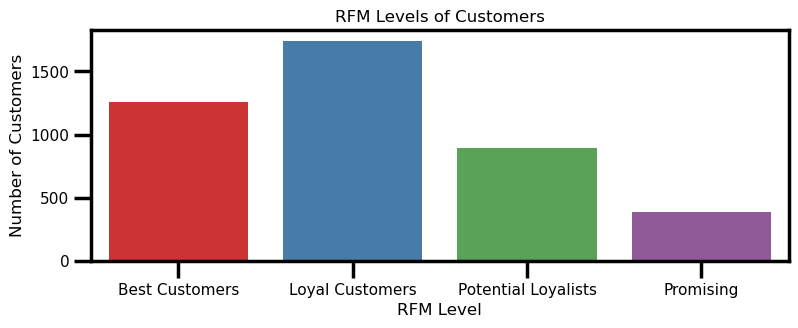

In [233]:
#barplot visualizing the number of customers per rfm level
plt.figure(figsize=(9,3))
sns.countplot(data = rfm_df, x = 'RFM_Level', palette = 'Set1')

plt.xlabel('RFM Level', fontsize = 12)
plt.ylabel('Number of Customers')
plt.title('RFM Levels of Customers')
plt.show()

<b>1 - Loyal Customers</b></br>
This is the largest segment.Indicates your business has a strong repeat customer base.These customers are valuable but not yet the very top spenders.<br>
<b>Business action:</b><br>
Retention campaigns, loyalty rewards, personalized offers

<b>2 - Best Customers</b> 
Second-largest group<br>
High RFM score (≥10) means:<br>
Recent purchases<br>
High frequency<br>
High monetary value<br>
<b>Business action:</b><br>
VIP programs, exclusive deals, early access to products

<b>3 - Potential Loyalists</b><br>
Moderate-sized group</br>
These customers are on the path to becoming loyal<br>
<b>Business action:</b></br>
Targeted promotions, onboarding emails, discounts to increase frequency

In [234]:
#segmenting customers
segmented_customers = rfm_df.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Total Price': ['mean', 'count']
})

In [235]:
segmented_customers

Recency   Frequency  Total Price      
                           mean        mean         mean count
RFM_Level                                                     
Best Customers        19.682288  223.976966  3756.467323  1259
Loyal Customers       71.038484   49.470994   769.496211  1741
Potential Loyalists  159.668904   17.657718   286.841567   894
Promising            259.714653    7.688946   145.674396   389

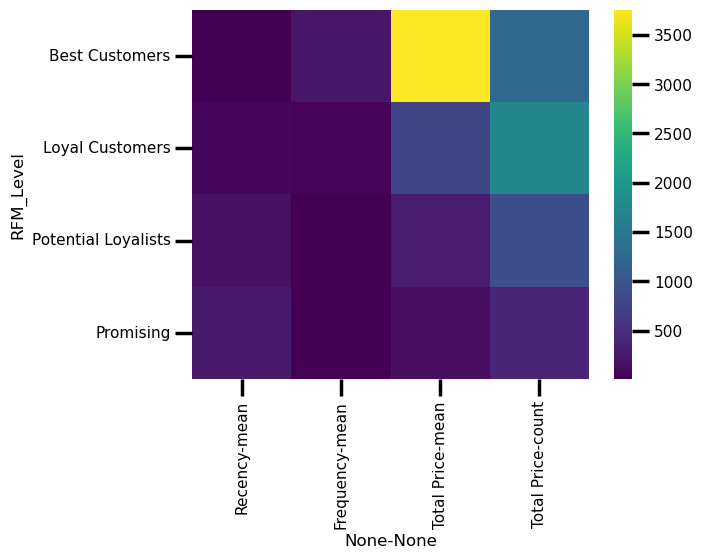

In [236]:
sns.heatmap(segmented_customers, cmap = 'viridis')
plt.show()

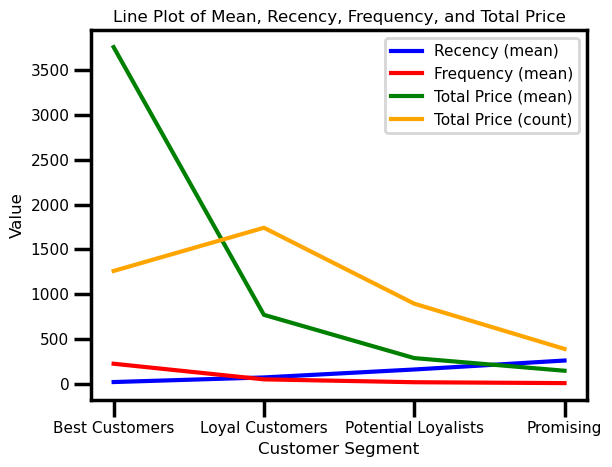

In [237]:
#trying to visualize segmented customers as a line chart

#extracting the columns to plot
recency_mean = segmented_customers.loc[:, ('Recency', 'mean')]
frequency_mean = segmented_customers.loc[:, ('Frequency', 'mean')]
tot_mean = segmented_customers.loc[:, ('Total Price', 'mean')]
tot_count = segmented_customers.loc[:, ('Total Price', 'count')]

#line plits
plt.plot(recency_mean, c = 'blue', label = 'Recency (mean)')
plt.plot(frequency_mean, c = 'red', label = 'Frequency (mean)')
plt.plot(tot_mean, c = 'green', label = 'Total Price (mean)')
plt.plot(tot_count, c = 'orange', label = 'Total Price (count)')


plt.xlabel('Customer Segment')
plt.ylabel('Value')
plt.title('Line Plot of Mean, Recency, Frequency, and Total Price')
plt.legend()
plt.show()

#### Scaling and Standardisation 

In [238]:

nocust_rfm_df = rfm_df[['Total Price', 'Frequency', 'Recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(nocust_rfm_df)
rfm_df_scaled.shape

(4283, 3)

In [239]:
# Convert rfm_df_scaled arraytype to dataframe

rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Total Price', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Total Price,Frequency,Recency
0,0.646839,0.404614,-0.905367
1,0.016891,-0.269239,-0.175704
2,-0.008197,-0.081809,-0.735446
3,-0.290850,-0.327252,2.173210
4,0.044196,-0.037183,-0.565524


#### K-Means

In [240]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

#### Finding optimum number of clusters<br>
##### Using Elbow Mehod / WCSS - within-cluster sum of squares

In [241]:
kmeans.labels_

array([3, 3, 3, ..., 3, 1, 3])

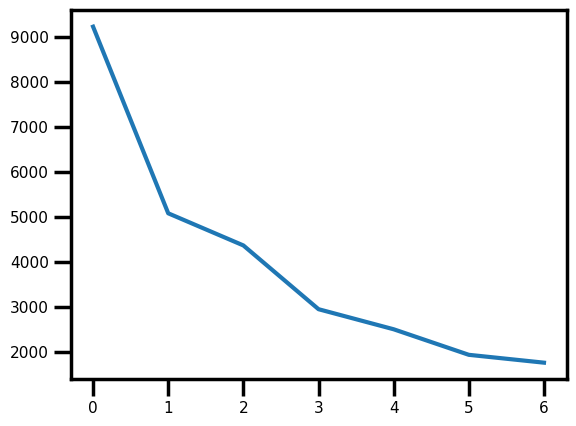

In [242]:

# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)
plt.show()



index starts from 0-1-2-3-4-5-6<br>
No of clusters are [2, 3, 4, 5, 6, 7, 8]<br>
So for 0th index no of clusters are 2,1st index 3 clusters and so on.
The elbow is the point after which the decrease in SSD becomes gradual rather than sharp.<br>
Conclusion: The optimal number of clusters for this dataset is where the elbow is most prominent, which is at \(k=3\).



### Silhouette score 
It is used to evaluate the quality of clusters created using clustering algorithms such as K-Means in terms of how well samples are clustered with other samples that are similar to each other. The Silhouette score is calculated for each sample of different clusters. To calculate the Silhouette score for each observation/data point, the following distances need to be found out for each observations belonging to all the clusters:

* Mean distance between the observation and all other data points in the same cluster. This distance can also be called a mean intra-cluster distance. The mean distance is denoted by a.
* Mean distance between the observation and all other data points of the next nearest cluster. This distance can also be called a mean nearest-cluster distance. The mean distance is denoted by b.

 The Silhouette Coefficient for a sample is $ S = \frac{(b - a)}{max(a, b)}$.

A silhouette score measures how well each data point fits within its assigned cluster compared to other clusters.<br>

Score range: -1 to +1<br>

Closer to 1 → very good clustering<br>

Around 0 → overlapping clusters<br>

Less than 0 → wrong clustering (points assigned to wrong clusters)

In [243]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.9305027865886387
For n_clusters=3, the silhouette score is 0.5694446548758819
For n_clusters=4, the silhouette score is 0.5915948557883868
For n_clusters=5, the silhouette score is 0.5783250442042873
For n_clusters=6, the silhouette score is 0.49807666978298304
For n_clusters=7, the silhouette score is 0.5072413498419945
For n_clusters=8, the silhouette score is 0.4848129733293761


According to interpretation the best number of clusters based on silhouette score = 4. The clusters formed with 4 groups are the most cohesive and well-separated among the options you tested. It has the highest silhouette score.But the Elbow method tells 3.

##### Final model with K = 4
Its depend on business requirement. Lets select k = 4

In [244]:
# final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)
clusters = kmeans.fit_predict(rfm_df_scaled)

In [245]:
kmeans.labels_

array([0, 0, 0, ..., 0, 3, 0])

In [246]:
# Assign Cluster Labels to the Original Data
rfm_df['cluster_id'] = kmeans.labels_
rfm_df.head()

,CustomerID,Total Price,Frequency,Recency,RFM_Score,RFM_Level,cluster_id
0,12347.0,4060.40,181,1,12,Best Customers,0
1,12348.0,1557.24,30,74,8,Loyal Customers,0
2,12349.0,1457.55,72,18,9,Loyal Customers,0
3,12350.0,334.40,17,309,4,Potential Loyalists,1
4,12352.0,1665.74,82,35,10,Best Customers,0


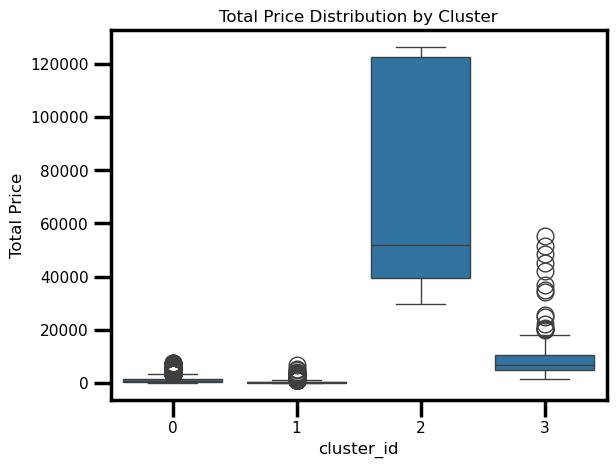

In [247]:
# plot
sns.boxplot(x='cluster_id', y='Total Price', data=rfm_df)
plt.title("Total Price Distribution by Cluster")
plt.show()


<b>Cluster 1 – High-Value Customers</b><br>
Highest median total price

Very wide IQR → large variation in spending

Many extreme high-value outliers (up to ~125,000)

Interpretation
This cluster contains high-spending customers, including VIP or wholesale buyers.

* Business action:
Premium offers, loyalty programs, personalized discounts


<b>Cluster 3 – Medium-Value Customers</b><br>

Moderate median total price

Several high-value outliers (up to ~55,000)

More consistent than Cluster 1

* Interpretation
Customers spend moderate amounts regularly, with some potential to upgrade.

* Business action:
Cross-sell and upsell campaigns

<b>Cluster 0 – Low-Value Customers</b><br>

Very low median spending

Small IQR

A few small outliers

* Interpretation
Occasional or low-frequency buyers.

* Business action:
Promotional offers, nudges for repeat purchases

<b>Cluster 2 – Very Low / Inactive Customers</b><br>

Lowest median total price

Tight distribution near zero

Minimal spending behavior

* Interpretation
New, inactive, or churn-risk customers.

* Business action:
Reactivation campaigns or churn analysis

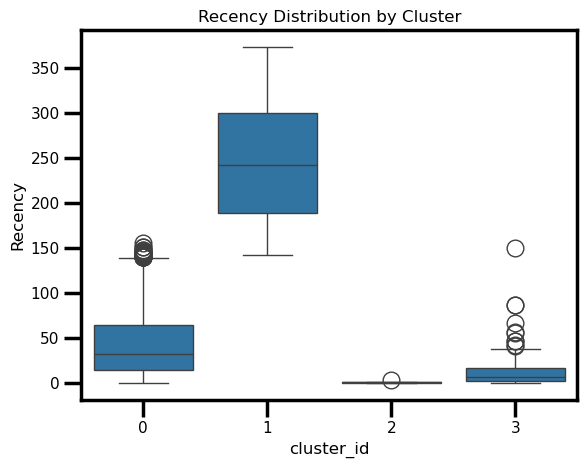

In [248]:
# box plot of cluster_id against recency
sns.boxplot(x='cluster_id', y='Recency', data=rfm_df)
plt.title("Recency Distribution by Cluster")
plt.show()

#### Interpretation

<b>Cluster 1 – Most Recent / Active Customers</b><br>

Lowest recency values (close to 0)

Very tight box → consistent recent purchases

Almost no outliers

* Interpretation:
These customers have purchased very recently and are highly active.

* Business action:
Maintain engagement with loyalty rewards and personalized offers

<b>Cluster 3 – Recently Active Customers</b><br>

Low median recency

Some higher outliers (customers starting to lapse)

* Interpretation:
Generally active customers, but a few are becoming inactive.

* Business action:
Timely reminders, follow-up emails, limited-time offers

<b>Cluster 0 – Moderately Recent Customers</b><br>

Moderate median recency

Wider spread → mixed behavior

Some customers haven’t purchased in a long time

* Interpretation:
Customers with inconsistent purchase behavior.

* Business action:
Reactivation or personalized engagement strategies

<b>Cluster 2 – Least Recent / Inactive Customers</b><br>

Highest median recency (~240+)

Large spread up to ~370

Clearly separated from other clusters

* Interpretation:
Customers who haven’t purchased for a long time → churn-risk segment.

* Business action:
Win-back campaigns, special discounts, churn analysis

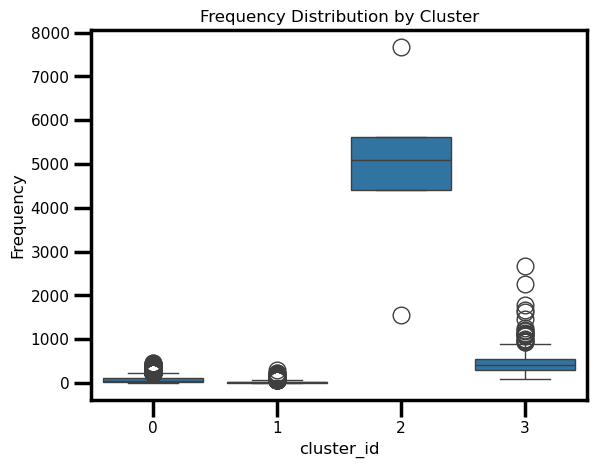

In [249]:
# Boxplot of cluster_id against frequency
sns.boxplot(x='cluster_id', y='Frequency', data=rfm_df)
plt.title("Frequency Distribution by Cluster")
plt.show()


<b>Cluster 1 – Very High-Frequency Customers</b><br>

Highest median frequency (~5,000)

Wide IQR → consistently frequent buyers

A few extreme outliers (very heavy buyers)

* Interpretation:
This cluster represents power users / extremely loyal customers who purchase very frequently.

* Business action:
VIP programs, bulk discounts, dedicated account management

<b> Cluster 3 – Medium-Frequency Customers</b><br>

Moderate median frequency (~400–500)

Several high-frequency outliers (up to ~2,700)

* Interpretation:
Regular buyers with strong potential to move into high-value segment.

* Business action:
Loyalty points, cross-selling, personalized recommendations

<b> Cluster 0 – Low-Frequency Customers</b><br>

Low median frequency (~100)

Narrow spread

Few moderate outliers

* Interpretation : 
Occasional or infrequent buyers.

* Business action:
Engagement campaigns, reminders, first-to-second purchase conversion

<b>Cluster 2 – Very Low-Frequency / One-time Buyers</b><br>

Lowest median frequency (near zero)

Very tight distribution

* Interpretation:
One-time, inactive, or churn-risk customers.

* Business action:
Reactivation offers, churn prevention strategies

#### Visualize the Clusters

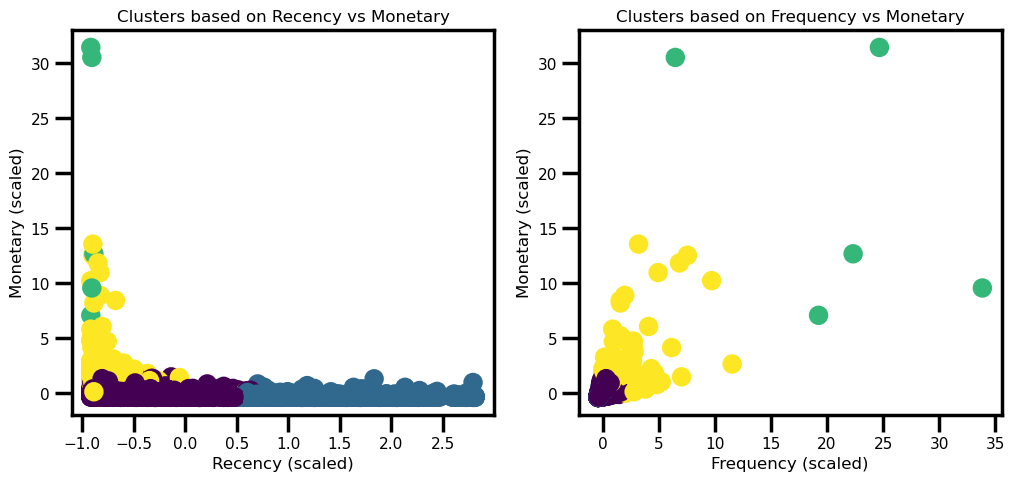

In [250]:


plt.figure(figsize=(12,5))

# Plot Recency vs Monetary
plt.subplot(1,2,1)
# plt.scatter(rfm_df_scaled[:,0], rfm_df_scaled[:,2], c=clusters, cmap='viridis')
plt.scatter(rfm_df_scaled['Recency'], rfm_df_scaled['Total Price'], c=clusters)

plt.title("Clusters based on Recency vs Monetary")
plt.xlabel("Recency (scaled)"),
plt.ylabel("Monetary (scaled)")


# Plot Frequency vs Monetary
plt.subplot(1,2,2)
plt.scatter(rfm_df_scaled["Frequency"], rfm_df_scaled["Total Price"], c=clusters, cmap='viridis')
plt.title("Clusters based on Frequency vs Monetary")

plt.xlabel("Frequency (scaled)")
plt.ylabel("Monetary (scaled)")
plt.show()



#### Analyze Each Segment (Summary Statistics)

In [251]:
#Checking men, median, standard deviation for different clusters
cluster_summary = rfm_df.groupby('cluster_id').agg({
    'Recency': ['mean','median','std'],
    'Frequency': ['mean','median','std'],
    'Total Price': ['mean','median','std']
}).round(2)

cluster_summary

Recency               Frequency                  Total Price  \
              mean median    std      mean  median      std        mean   
cluster_id                                                                
0            42.75   32.0  36.13     74.92    51.0    72.61     1183.58   
1           247.72  242.0  66.16     27.65    18.0    31.11      434.51   
2             1.00    1.0   1.22   4865.20  5092.0  2221.84    74062.34   
3            12.51    7.0  16.91    490.63   418.0   331.72     9048.00   

                                
              median       std  
cluster_id                      
0             776.85   1160.80  
1             298.76    539.82  
2           51879.47  46837.41  
3            6910.78   8001.55

## Conclusion

Based on Recency (R), Frequency (F), and Monetary (Total Price) distributions below is the final table.

| Cluster ID    | Recency              | Frequency | Monetary  | RFM Segment                      |
| ------------- | -------------------- | --------- | --------- | -------------------------------- |
| **Cluster 1** | Very Low (recent)    | Very High | Very High | **Best Customers**               |
| **Cluster 3** | Low                  | Medium    | Medium    | **Loyal Customers**              |
| **Cluster 0** | Medium               | Low       | Low       | **Promising Customers**          |
| **Cluster 2** | Very High (inactive) | Very Low  | Very Low  | **Needs Attention / Churn Risk** |

### Business Actions per Segment

| Segment         | Strategy                                        |
| --------------- | ----------------------------------------------- |
| Best Customers  | VIP rewards, exclusive deals, early access      |
| Loyal Customers | Cross-sell, loyalty points, personalized offers |
| Promising       | Discounts, nudges for repeat purchase           |
| Needs Attention | Win-back campaigns, churn analysis              |

### Final Case Study Conclusion

“Using RFM-based clustering, customers were segmented into four distinct groups. Cluster 1 represents best customers with high purchase frequency, recent activity, and high monetary value. Cluster 3 includes loyal customers with consistent engagement. Cluster 0 contains low-value but promising customers, while cluster 2 represents inactive customers at risk of churn. This segmentation enables targeted marketing strategies to improve customer retention and maximize lifetime value.”
